In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

# 使用 colab 環境的同學請執行以下程式碼
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

import os
from google.colab import drive 
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
#os.system("mkdir ./your_path/cupoy_cv_part4") # 可以自己改路徑



`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


0

In [2]:
%cd 'gdrive/My Drive/cupoy_cv_part4'

/content/gdrive/My Drive/cupoy_cv_part4


In [ ]:
# 如果要使用 kaggle API 下載資料的話，請用以下程式碼
# os.environ['KAGGLE_USERNAME'] = '____' # 請按照 Day42 簡報內容，獲取 kaggle api 需要用到的 username
# os.environ['KAGGLE_KEY'] = '____' # 請按照 Day42 簡報獲取 kaggle api 需要用到的 key
# !kaggle competitions download -c facial-keypoints-detection
# !unzip test.zip
# !unzip training.zip

In [3]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [4]:
imgs_train, points_train = load_data(dirname = './training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Using TensorFlow backend.


In [6]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [7]:
model = get_model()
# 配置 loss funtion 和 optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

In [8]:
# 印出網路結構
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)        

In [9]:
from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
hist = History()

In [10]:
# training the model
hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
                       points_train, 
                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
                       shuffle=True, epochs=150, verbose=1)
# save the model weights
model.save_weights('weights.h5')
# save the model
model.save('model.h5')

Train on 1712 samples, validate on 428 samples
Epoch 1/150
1712/1712 [==============================] - 7s 4ms/step - loss: 0.0064 - val_loss: 0.0021

Epoch 00001: val_loss improved from inf to 0.00210, saving model to best_weights.h5
Epoch 2/150
1712/1712 [==============================] - 1s 469us/step - loss: 0.0017 - val_loss: 0.0021

Epoch 00002: val_loss improved from 0.00210 to 0.00209, saving model to best_weights.h5
Epoch 3/150
1712/1712 [==============================] - 1s 462us/step - loss: 0.0014 - val_loss: 0.0019

Epoch 00003: val_loss improved from 0.00209 to 0.00189, saving model to best_weights.h5
Epoch 4/150
1712/1712 [==============================] - 1s 463us/step - loss: 0.0012 - val_loss: 0.0019

Epoch 00004: val_loss improved from 0.00189 to 0.00187, saving model to best_weights.h5
Epoch 5/150
1712/1712 [==============================] - 1s 465us/step - loss: 0.0011 - val_loss: 0.0018

Epoch 00005: val_loss improved from 0.00187 to 0.00185, saving model to best_

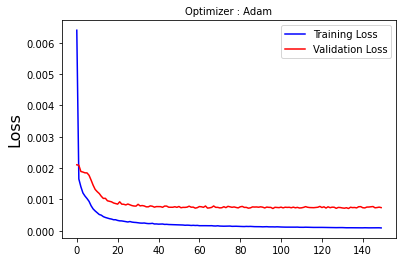

In [11]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

In [13]:
# 讀取測試資料集
imgs_test, _ = load_data(dirname = './test.csv')

In [14]:

# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

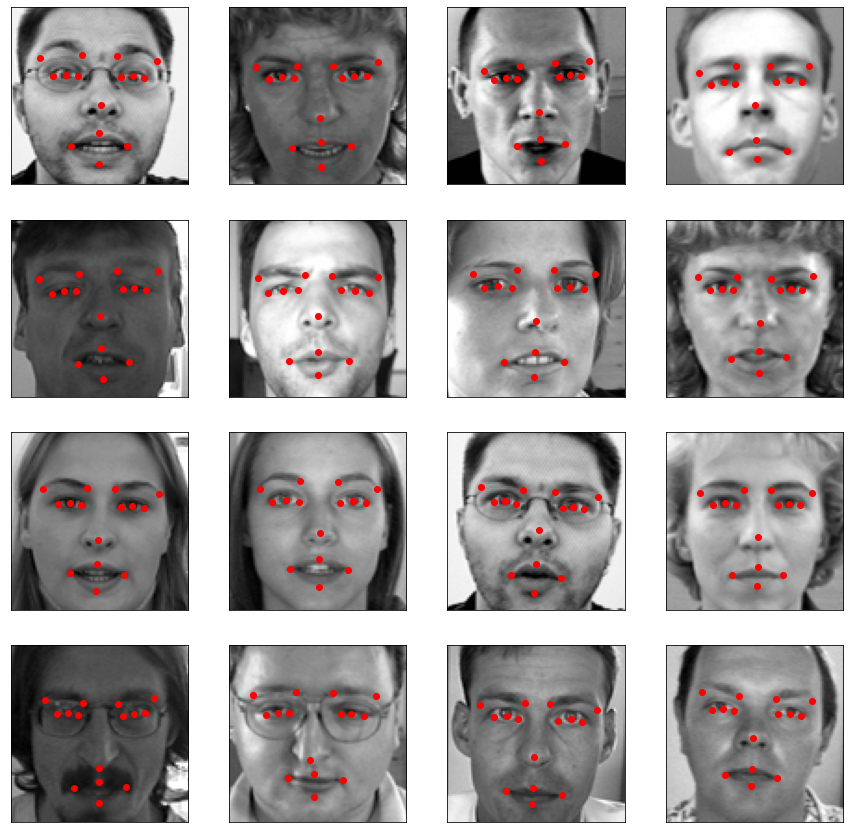

In [15]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

In [16]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
# Your code
from keras.preprocessing.image import ImageDataGenerator

In [18]:
datagen = ImageDataGenerator(horizontal_flip=True)


In [19]:
x_train = imgs_train.reshape(-1, 96, 96, 1)


In [20]:
hist_model_with_augment =  model_with_augment.fit_generator(datagen.flow(x_train, points_train,batch_size = 32),
                                 steps_per_epoch = len(x_train) // 32, epochs=100,
                                 callbacks=[checkpoint, hist], shuffle=True,
                                 validation_data=(x_train, points_train))

Epoch 1/100
66/66 [==============================] - 2s 33ms/step - loss: 0.0046 - val_loss: 0.0011

Epoch 00001: val_loss did not improve from 0.00071
Epoch 2/100
66/66 [==============================] - 2s 25ms/step - loss: 0.0015 - val_loss: 0.0011

Epoch 00002: val_loss did not improve from 0.00071
Epoch 3/100
66/66 [==============================] - 2s 24ms/step - loss: 0.0013 - val_loss: 0.0010

Epoch 00003: val_loss did not improve from 0.00071
Epoch 4/100
66/66 [==============================] - 2s 24ms/step - loss: 0.0012 - val_loss: 9.5310e-04

Epoch 00004: val_loss did not improve from 0.00071
Epoch 5/100
66/66 [==============================] - 2s 24ms/step - loss: 0.0011 - val_loss: 8.5139e-04

Epoch 00005: val_loss did not improve from 0.00071
Epoch 6/100
66/66 [==============================] - 2s 24ms/step - loss: 9.4259e-04 - val_loss: 7.3095e-04

Epoch 00006: val_loss did not improve from 0.00071
Epoch 7/100
66/66 [==============================] - 2s 24ms/step - loss

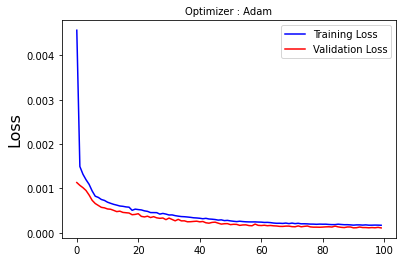

In [21]:
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model_with_augment.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model_with_augment.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

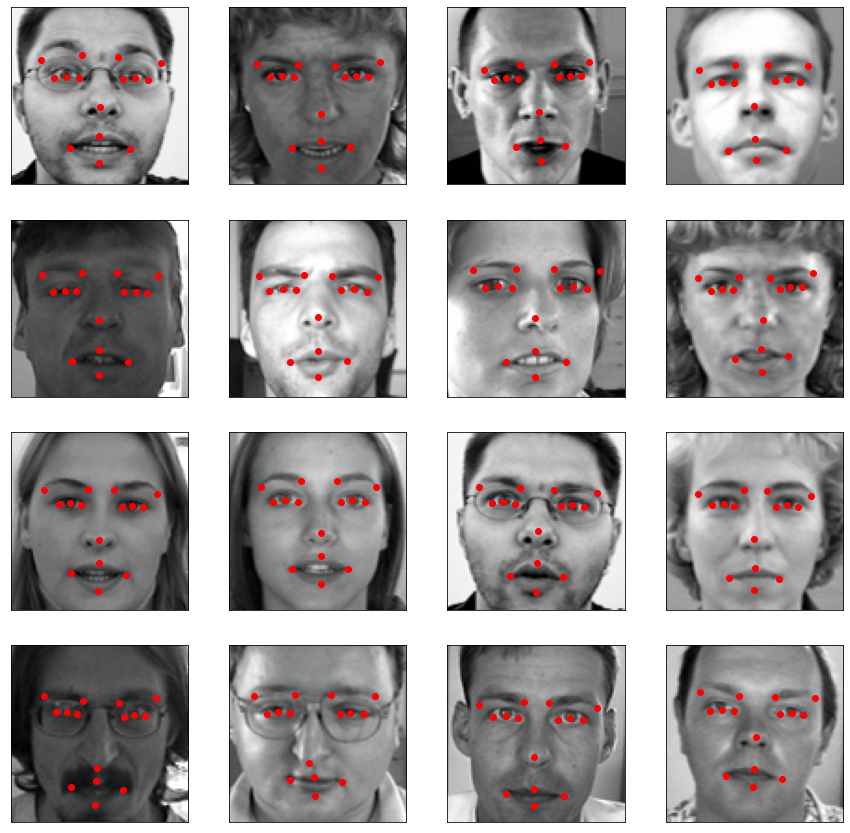

In [22]:
fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
points_test = model_with_augment.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))